In [1]:
import hawkesbook as hawkes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from numba import njit, prange
import numpy.random as rnd
from scipy.optimize import fsolve, minimize
import numpy.random as rnd
from tqdm import tqdm

from numpy.testing import assert_allclose


In [2]:
#Parameters
empMean, empVar, empAutoCov = hawkes.empirical_moments([1, 2, 2.1, 2.3, 4.5, 9.9], T=10, τ=2, lag=1)
assert min(empMean, empVar) > 0

assert hawkes.hawkes_intensity(1, [], [1, None, None]) == 1
assert hawkes.hawkes_intensity(2, [1], [1, lambda x: np.exp(-x), None]) == 1 + np.exp(-1)

assert hawkes.exp_hawkes_intensity(1, [0.5], [1.0, 2.0, 3.0]) == hawkes.hawkes_intensity(1, [0.5], (1, lambda t: 2*np.exp(-3*t), None))

testα = 3
testβ = 4
testμ = lambda x: testα*np.exp(-testβ * x)
testM = lambda t: (testα/testβ) * (1 - np.exp(-testβ*t))

testα = testβ = 1
testμ = lambda x: testα*np.exp(-testβ * x)
testM = lambda t: (testα/testβ) * (1 - np.exp(-testβ*t))

rnd.seed(1)
simTimes = hawkes.simulate_inverse_compensator([1, testμ, testM], hawkes.hawkes_compensator, 10)
print(simTimes)

print("Testing log likelihoods")
testObs = np.array([0.5, 0.75])
testT = 100
test𝛉 = np.array([1, 1, 2])
assert hawkes.exp_log_likelihood(testObs, testT, test𝛉) == hawkes.log_likelihood(testObs, testT, test𝛉,
    hawkes.exp_hawkes_intensity, hawkes.exp_hawkes_compensator)

assert_allclose(hawkes.exp_log_likelihood(testObs, testT, test𝛉),
               hawkes.log_likelihood(testObs, testT, test𝛉, hawkes.exp_hawkes_intensity, hawkes.exp_hawkes_compensator),
               0.1)

print(f"Passed! Exp version = {hawkes.exp_log_likelihood(testObs, testT, test𝛉)} == general version = {hawkes.log_likelihood(testObs, testT, test𝛉, hawkes.exp_hawkes_intensity, hawkes.exp_hawkes_compensator)}")


[ 0.87461629  5.45967488 21.49146196 28.68843833 35.6076635  41.99065897
 46.67879721 49.77768007 51.79555761 52.72471855]
Testing log likelihoods
Passed! Exp version = -100.5259230158199 == general version = -100.5259230158199


In [3]:
# Test simulation methods for exponential case
sim𝛉 = np.array([1, 2, 3])
testT = 1000

hawkes.numba_seed(1)
N_T = []
max_t = []
for r in tqdm(range(1000)):
    times = hawkes.exp_simulate_by_composition(sim𝛉, 1000)
    N_T.append(len(times[times < testT]))
    max_t.append(times[-1])
print(f"Over [0, 100] we had {np.mean(N_T)} arrivals on average by composition method")

hawkes.numba_seed(1)
N_T = []
for r in tqdm(range(10000)):
    N_T.append(len(hawkes.exp_simulate_by_composition_alt(sim𝛉, testT)))
print(f"Over [0, 100] we had {np.mean(N_T)} arrivals on average by alternative composition method")


hawkes.numba_seed(1)
N_T = []
for r in tqdm(range(1000)):
    N_T.append(len(hawkes.exp_simulate_by_thinning(sim𝛉, testT)))
print(f"Over [0, 100] we had {np.mean(N_T)} arrivals on average by thinning method")

testλ, testα, testβ = sim𝛉
testμ = lambda x: testα*np.exp(-testβ * x)
testM = lambda t: (testα/testβ) * (1 - np.exp(-testβ*t))

rnd.seed(1)
N_T = []
max_t = []
for r in tqdm(range(10)):
    times = hawkes.simulate_inverse_compensator([testλ, testμ, testM], hawkes.hawkes_compensator, 500)
    N_T.append(len(times[times < testT]))
    max_t.append(times[-1])
print(f"Over [0, 100] we had {np.mean(N_T)} arrivals on average by inverse compensator method")

hawkes.numba_seed(1)

sim𝛉 = np.array([1, 2, 3])

testT = 1000
testObs = hawkes.exp_simulate_by_thinning(sim𝛉, testT)
print(f"Testing log likelihoods on larger sample (of size {len(testObs)})")

print(f"Exp version = {hawkes.exp_log_likelihood(testObs, testT, test𝛉)} == general version = {hawkes.log_likelihood(testObs, testT, test𝛉, hawkes.exp_hawkes_intensity, hawkes.exp_hawkes_compensator)}")

assert_allclose(hawkes.exp_log_likelihood(testObs, testT, test𝛉),
               hawkes.log_likelihood(testObs, testT, test𝛉, hawkes.exp_hawkes_intensity, hawkes.exp_hawkes_compensator),
               0.1)
print("Passed!")

testMean, testVar, testAutoCov = testMoments = hawkes.exp_moments([1, 2, 3], τ=2, lag=1)
assert min(testMean, testVar) > 0

assert hawkes.exp_gmm_loss(np.array([1.0, 2.0, 3.0]), 2, 1, testMoments + 2, np.eye(3)) == 12.0

print(hawkes.exp_gmm(np.array([1.0, 1.1, 1.2, 5.0]), 10, 2, 1))

print("Testing EM algorithm")
print(hawkes.exp_em(np.array([1.0, 1.1, 1.2, 5.0]), 6.0, np.array([1.0, 2.0, 3.0]), 10, 1, True))

fit = hawkes.exp_mle(np.array([1.0, 1.1, 1.2, 5.0]), 10)

  0%|          | 0/10000 [00:00<?, ?it/s]

Over [0, 100] we had 1000.0 arrivals on average by composition method


  0%|          | 0/1000 [00:00<?, ?it/s]

Over [0, 100] we had 3001.6727 arrivals on average by alternative composition method


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\leey79\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Over [0, 100] we had 2997.004 arrivals on average by thinning method


 20%|██        | 2/10 [00:20<01:21, 10.18s/it]<ipython-input-3-386131e88a40>:29: RuntimeWarning: overflow encountered in exp
  testM = lambda t: (testα/testβ) * (1 - np.exp(-testβ*t))
100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


Over [0, 100] we had 400.7 arrivals on average by inverse compensator method
Testing log likelihoods on larger sample (of size 3171)
Exp version = 1272.6547106332969 == general version = 1272.6547106333023


  0%|          | 0/10 [00:00<?, ?it/s]

Passed!
[ 0.32565403  4.03761246 11.57817107]
Testing EM algorithm


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

0.44704933808934105 1.0007342034377777 7.796046184269571
0.48231233539097457 2.156074051029627 8.537073271663612
0.4356061019096442 2.9590164958781404 8.636260877107658
0.40932793173954757 3.3338146522394907 8.660619152151655
0.39940236804009 3.4721618664958314 8.668567136183254
0.39607728388870306 3.5185845622087424 8.67120297098642
0.39500238552196465 3.533635645526565 8.672059946158697
0.39465847161388296 3.538458599689333 8.672335224573061
0.3945487648465509 3.539998061662045 8.672423192636249
0.39451379964426597 3.540488825413913 8.67245124855996
(array([0.3945138 , 3.54048883, 8.67245125]), array([-6.44934898, -4.79448244, -4.44257839, -4.33275814, -4.3119349 ,
       -4.30925345, -4.30895862, -4.30892792, -4.30892478, -4.30892446]))


In [4]:
# Calculate each arrival as a (fractional) number of days since the
# beginning of the observation period
#timeToQuake = quakes.index - pd.Timestamp("1/1/1973")
#ts = np.array(timeToQuake.total_seconds() / 60 / 60 / 24)

# Calculate the length of the observation period
#obsPeriod = pd.Timestamp("31/12/2020") - pd.Timestamp("1/1/1973")
#T = obsPeriod.days


Exp Hawkes MLE fit:  [0.97746491 2.04235149 2.95228933]
Exp Hawkes EM fit:  [0.97746491 2.04235149 2.95228933]
EM was a better fit than MLE in this case
The exponentially-decaying Hawkes was the better fit with BIC=-2746.20.
The power-law Hawkes had BIC=-2733.42.
Ground truth = (1, 2, 3)


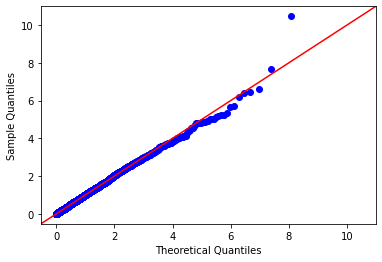

In [5]:
# Calculate the maximum likelihood estimate for the Hawkes process
# with an exponentially decaying intensity
𝛉_exp_mle = hawkes.exp_mle(testObs, testT)
print("Exp Hawkes MLE fit: ", 𝛉_exp_mle)

# Calculate the EM estimate or the same type of Hawkes process
𝛉_exp_em = hawkes.exp_em(testObs, testT, iters=100)
print("Exp Hawkes EM fit: ", 𝛉_exp_mle)

# Get the likelihoods of each fit to find the better one
ll_mle = hawkes.exp_log_likelihood(testObs, testT, 𝛉_exp_mle)
ll_em = hawkes.exp_log_likelihood(testObs, testT, 𝛉_exp_em)

if ll_mle > ll_em:
    print("MLE was a better fit than EM in this case")
    𝛉_exp = 𝛉_exp_mle
    ll_exp = ll_mle
else:
    print("EM was a better fit than MLE in this case")
    𝛉_exp = 𝛉_exp_em
    ll_exp = ll_em

# Fit instead the Hawkes with a power-law decay
𝛉_pl = hawkes.power_mle(testObs, testT)
ll_pl = hawkes.power_log_likelihood(testObs, testT, 𝛉_pl)

# Compare the BICs
#put len() for testT if it is an array
BIC_exp = 3 * np.log(testT) - 2 * ll_exp
BIC_pl = 4 * np.log(testT) - 2 * ll_pl
if BIC_exp < BIC_pl:
    print(f"The exponentially-decaying Hawkes was the better fit with BIC={BIC_exp:.2f}.")
    print(f"The power-law Hawkes had BIC={BIC_pl:.2f}.")
else:
    print(f"The power-law Hawkes was the better fit with BIC={BIC_pl:.2f}.")
    print(f"The exponentially-decaying Hawkes had BIC={BIC_exp:.2f}.")

# Create a Q-Q plot for the exponential-decay fit by
# first transforming the points to a unit-rate Poisson
# process as outlined by the random time change theorem
print(f"Ground truth = {testλ, testα, testβ }")
tsShifted = hawkes.exp_hawkes_compensators(testObs, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=False, line="45")
plt.show()

In [65]:
print(f'GMM test:')
print(hawkes.exp_gmm(testObs, 10, 200, 1))

GMM test:
[1. 2. 3.]


In [68]:
#Plot mean square error with estimated parameters with the function tau
results=[]
for t in range (1,200):
    res = hawkes.exp_gmm(testObs, 10, t, 1)
    results.append(res)

print (results)

[array([33.33895735, 26.24865433,  0.81386071]), array([0.56180695, 5.84397244, 6.73154033]), array([ 1.37921953, 29.84827749, 44.91744335]), array([ 0.47513531, 33.55235072, 37.77666015]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2., 3.]), array([1., 2

In [72]:

for t in range (1,200):
    x = len(t)

y = results
 
# plotting the points
plt.plot(x, y)
 
# function to show the plot
plt.show()

TypeError: object of type 'int' has no len()

In [60]:
print(f'GMM test:')
print(hawkes.exp_gmm(testObs, hawkes.exp_gmm_loss(simθ, 1, 1, hawkes.empirical_moments(0, testT, 20, 1), W) ,2 , 1))

GMM test:
[0.54624616 5.30681296 6.39484284]


In [ ]:
##Fitting Covid Casses to hawkes

In [ ]:
#Using csv file, to determine if covid cases follow a Hawkes distribution
cases = pd.read_csv(r"C:\Users\leey79\Desktop\Singapore Covid.csv")



In [ ]:
cases.index = pd.to_datetime(cases.Date_reported.astype(str) + cases.Time, Date_reportedfirst=True)
cases.sort_index(inplace=True)

In [ ]:
# Calculate each arrival as a (fractional) number of days since the
# beginning of the observation period
dateofcases = cases.index - Date_reported("1/3/2020")
ts = np.array(dailycases.total_cases() / 24)


In [ ]:
# Calculate the length of the observation period
obsPeriod = pd.Timestamp("31/12/2020") - pd.Timestamp("1/1/1973")
T = obsPeriod.days

# Calculate the maximum likelihood estimate for the Hawkes process
# with an exponentially decaying intensity
theta_exp_mle = hawkes.exp_mle(ts, T)
print("Exp Hawkes MLE fit: ", theta_exp_mle)

# Calculate the EM estimate or the same type of Hawkes process
theta_exp_em = hawkes.exp_em(ts, T, iters=100)
print("Exp Hawkes EM fit: ", theta_exp_mle)

# Get the likelihoods of each fit to find the better one
ll_mle = hawkes.exp_log_likelihood(ts, T, theta_exp_mle)
ll_em = hawkes.exp_log_likelihood(ts, T, theta_exp_em)

if ll_mle > ll_em:
    print("MLE was a better fit than EM in this case")
    theta_exp = theta_exp_mle
    ll_exp = ll_mle
else:
    print("EM was a better fit than MLE in this case")
    theta_exp = theta_exp_em
    ll_exp = ll_em

# Fit instead the Hawkes with a power-law decay
theta_pl = hawkes.power_mle(ts, T)
ll_pl = hawkes.power_log_likelihood(ts, T, theta_pl)

# Compare the BICs
BIC_exp = 3 * np.log(len(ts)) - 2 * ll_exp
BIC_pl = 4 * np.log(len(ts)) - 2 * ll_pl
if BIC_exp < BIC_pl:
    print(f"The exponentially-decaying Hawkes was the better fit with BIC={BIC_exp:.2f}.")
    print(f"The power-law Hawkes had BIC={BIC_pl:.2f}.")
else:
    print(f"The power-law Hawkes was the better fit with BIC={BIC_pl:.2f}.")
    print(f"The exponentially-decaying Hawkes had BIC={BIC_exp:.2f}.")

# Create a Q-Q plot for the exponential-decay fit by
# first transforming the points to a unit-rate Poisson
# process as outlined by the random time change theorem
tsShifted = hawkes.exp_hawkes_compensators(ts, theta_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=False, line="45")
plt.show()